## 데이터 준비

In [ ]:
!pip install torch
!pip install transformers
!pip install sentencepiece
!pip install dataset
!pip install nlpaug

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class KcELECTRAWithDropout(nn.Module):
    def __init__(self):
        super(KcELECTRAWithDropout, self).__init__()
        self.electra = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base", num_labels=7)
        self.dropout = nn.Dropout(p=0.7)  # 드롭아웃 확률 증가
        self.batch_norm = nn.BatchNorm1d(7)  # 감정 분류 클래스 수와 동일

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = self.dropout(outputs.logits)
        logits = self.batch_norm(logits)  # Batch Normalization 적용
        return outputs

In [ ]:
# 데이터 로드 및 전처리
short_sen = pd.read_csv('/content/단발성_대화_정리.csv')
long_sen = pd.read_csv('/content/연속적_대화_정리.csv')

short_sen = short_sen[['Sentence', 'Emotion']]
short_sen = short_sen.rename(columns={"Sentence": 'sentence', "Emotion": 'emotion'})

emotion_cols = ['행복', '중립', '슬픔', '공포', '혐오', '분노', '놀람']
long_sen['emotion'] = long_sen[emotion_cols].idxmax(axis=1)
long_sen = long_sen.rename(columns={"Unnamed: 1": 'sentence'})

kor_to_eng_emotion = {
    "분노": "angry", "행복": "happy", "슬픔": "sad", "중립": "neutral",
    "놀람": "surprise", "공포": "fear", "혐오": "disgust"
}

short_sen['emotion'] = short_sen['emotion'].map(kor_to_eng_emotion)
long_sen['emotion'] = long_sen['emotion'].map(kor_to_eng_emotion)

emotion_dict = {"angry": 0, "happy": 1, "sad": 2, "neutral": 3, "surprise": 4, "fear": 5, "disgust": 6}
short_sen['emotion'] = short_sen['emotion'].map(emotion_dict)
long_sen['emotion'] = long_sen['emotion'].map(emotion_dict)

short_sen = short_sen.dropna(subset=['emotion'])
long_sen = long_sen.dropna(subset=['emotion'])

# 데이터셋 병합
data = pd.concat([short_sen[['sentence', 'emotion']], long_sen[['sentence', 'emotion']]], axis=0)

# 중립 데이터와 다른 감정 데이터 분리
neutral_data = data[data['emotion'] == 3.0]
other_data = data[data['emotion'] != 3.0]

# 중립 데이터 언더샘플링
if len(neutral_data) > len(other_data):
    neutral_data_sample = neutral_data.sample(n=len(other_data), random_state=42)  # 중립 데이터 일부만 사용
    balanced_data = pd.concat([other_data, neutral_data_sample])
else:
    balanced_data = data  # 중립 데이터가 적으면 그대로 사용

# 학습/테스트 데이터 분할
train_data, test_data = train_test_split(balanced_data, test_size=0.2, random_state=42)

<ipython-input-14-6eeec77c9021>:9: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  long_sen['emotion'] = long_sen[emotion_cols].idxmax(axis=1)


#데이터 클래스, 데이터 로더 준비

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data.iloc[index]['sentence']
        emotion = self.data.iloc[index]['emotion']

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(emotion, dtype=torch.long)
        }

# 토크나이저 및 데이터 로더 준비
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
train_dataset = EmotionDataset(train_data, tokenizer, max_len=64)
test_dataset = EmotionDataset(test_data, tokenizer, max_len=64)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#학습 함수 및 평가 함수 셀

In [ ]:
model = KcELECTRAWithDropout().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.1)  # weight decay 추가

# 손실 함수에 가중치 추가
class_weights = torch.tensor([1.5, 1.5, 1.5, 0.5, 1.5, 1.5, 1.5]).to(device)
criterion = CrossEntropyLoss(weight=class_weights)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)


In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for data in tqdm(data_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    correct_predictions = 0
    total_loss = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

# Early Stopping 설정
early_stop_threshold = 3  # 개선되지 않는 에포크 수 기준
no_improvement_count = 0
best_test_loss = float('inf')  # 가장 낮은 검증 손실 초기화

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # 학습
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train loss: {train_loss}, accuracy: {train_acc}")

    # 평가
    test_acc, test_loss = eval_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Test loss: {test_loss}, accuracy: {test_acc}")

    # Early Stopping 체크
    if test_loss < best_test_loss:
        best_test_loss = test_loss  # 새로운 최저 손실 갱신
        no_improvement_count = 0  # 개선되었으므로 카운트 리셋
    else:
        no_improvement_count += 1
        print(f"No improvement in test loss for {no_improvement_count} epoch(s).")

    # 개선되지 않는 에포크 수가 임계값을 넘으면 학습 중단
    if no_improvement_count >= early_stop_threshold:
        print(f"Early stopping at epoch {epoch + 1}")
        break

Epoch 1/10


100%|██████████| 965/965 [01:34<00:00, 10.25it/s]


Train loss: 1.2398339172719055, accuracy: 0.48374141728203135
Test loss: 1.0477300796134412, accuracy: 0.5524031610312217
Epoch 2/10


100%|██████████| 965/965 [01:34<00:00, 10.27it/s]


Train loss: 0.9397618086226863, accuracy: 0.59952714082135
Test loss: 1.0428097186502345, accuracy: 0.5606943904650862
Epoch 3/10


100%|██████████| 965/965 [01:33<00:00, 10.28it/s]


Train loss: 0.76769185112548, accuracy: 0.6775165176836377
Test loss: 1.1136469349634548, accuracy: 0.5777950511724317
No improvement in test loss for 1 epoch(s).
Epoch 4/10


100%|██████████| 965/965 [01:34<00:00, 10.27it/s]


Train loss: 0.6038072820617745, accuracy: 0.7423241352506801
Test loss: 1.2531244725235238, accuracy: 0.5701515740380878
No improvement in test loss for 2 epoch(s).
Epoch 5/10


100%|██████████| 965/965 [01:34<00:00, 10.26it/s]


Train loss: 0.4668520970588521, accuracy: 0.8029213628708382
Test loss: 1.3605122524352113, accuracy: 0.5675605648400052
No improvement in test loss for 3 epoch(s).
Early stopping at epoch 5


#학습 결과 시각화 셀

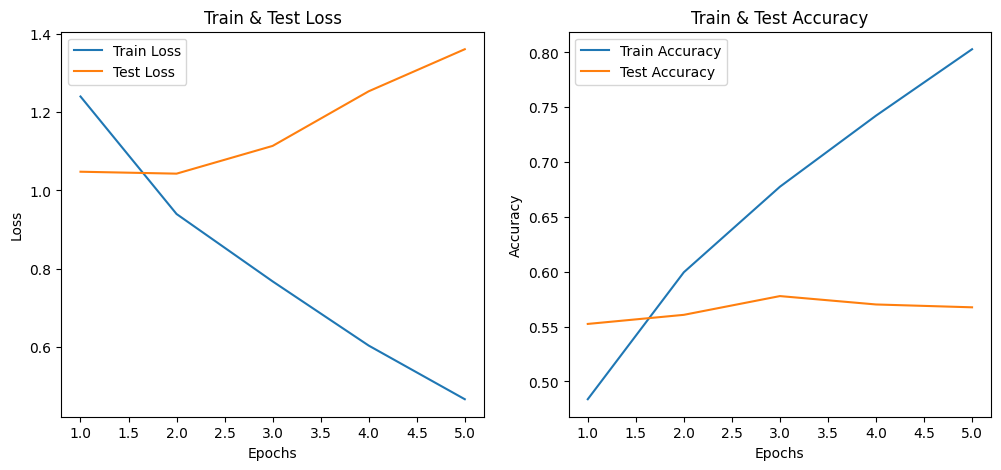

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')  # float형 값 사용
plt.plot(epochs_range, test_losses, label='Test Loss')    # float형 값 사용
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies], label='Train Accuracy')  # 텐서를 CPU로 옮겨서 numpy() 호출
plt.plot(epochs_range, [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in test_accuracies], label='Test Accuracy')    # 텐서를 CPU로 옮겨서 numpy() 호출
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy')
plt.legend()

plt.show()

#실시간 감정 예측 셀

In [ ]:
emotion_dict_reverse = {0: "angry", 1: "happy", 2: "sad", 3: "neutral", 4: "surprise", 5: "fear", 6: "disgust"}

def predict(predict_sentence):
    encoding = tokenizer(
        predict_sentence,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128,
        add_special_tokens=True
    ).to(device)

    with torch.no_grad():
        outputs = model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()

    emotion = emotion_dict_reverse[predicted_class]
    print(f">> 입력하신 내용의 감정은 '{emotion}'입니다.")

# 실시간 감정 예측 실행
while True:
    sentence = input("하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): ")
    if sentence.upper() == "QUIT":
        print("감정 분석을 종료합니다.")
        break
    predict(sentence)
    print("\n")

하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 오늘 재미있었어
>> 입력하신 내용의 감정은 'happy'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 행복해
>> 입력하신 내용의 감정은 'happy'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 비꼬지마
>> 입력하신 내용의 감정은 'disgust'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 아 진짜 너무 실허어
>> 입력하신 내용의 감정은 'sad'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 아 진짜 너무 싫어
>> 입력하신 내용의 감정은 'disgust'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 오늘 부장이 퇴근 30분전에 갑자기 일 던져주는거 있지?
>> 입력하신 내용의 감정은 'surprise'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 완전 극혐이야
>> 입력하신 내용의 감정은 'disgust'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 그래서 울었어
>> 입력하신 내용의 감정은 'sad'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 그 부장 뒤에서는 사람들 엄청 험담하고 최악이야
>> 입력하신 내용의 감정은 'disgust'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 술 마시고 나서는 완전 인사불성되서
>> 입력하신 내용의 감정은 'sad'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 너무 무섭다
>> 입력하신 내용의 감정은 'fear'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 너 이새끼
>> 입력하신 내용의 감정은 'angry'입니다.


하고 싶은 말을 입력해주세요 (종료하려면 'QUIT' 입력): 쟤는 뭐하니?
>> 입력하신 내용의 감정은 'surpris

emotion
1.0    6037
4.0    5898
0.0    5665
5.0    5468
6.0    5429
2.0    5267
3.0    4831
Name: count, dtype: int64


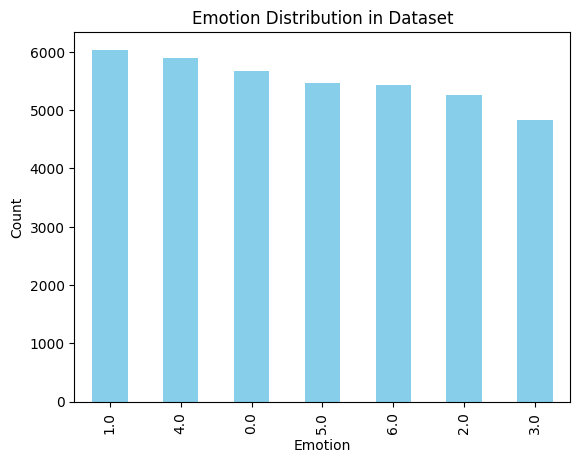

In [ ]:
# 각 감정별 데이터 개수 확인
emotion_counts = data['emotion'].value_counts()

# 감정별 데이터 개수 출력
print(emotion_counts)

# 감정 비율 시각화
import matplotlib.pyplot as plt

emotion_counts.plot(kind='bar', color='skyblue')
plt.title("Emotion Distribution in Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

In [ ]:
print(f"단발성 대화 데이터: {short_sen.shape}")
print(f"연속적 대화 데이터: {long_sen.shape}")
print(f"병합된 데이터: {data.shape}")

print(train_data['emotion'].value_counts())
print(test_data['emotion'].value_counts())

단발성 대화 데이터: (38594, 2)
연속적 대화 데이터: (1, 14)
병합된 데이터: (38595, 2)
emotion
1.0    4865
4.0    4721
0.0    4515
5.0    4372
6.0    4299
2.0    4247
3.0    3857
Name: count, dtype: int64
emotion
4.0    1177
1.0    1172
0.0    1150
6.0    1130
5.0    1096
2.0    1020
3.0     974
Name: count, dtype: int64


##학습 후 모델 저장

In [ ]:
import os
import torch

# Google Drive에 저장할 디렉토리 경로와 파일 이름 설정
model_dir = "/content/drive/MyDrive/TextModel"
model_save_path = os.path.join(model_dir, "Text_model.pth")

# 디렉토리가 없다면 생성
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 모델 가중치 저장
torch.save(model.state_dict(), model_save_path)

print(f"Model has been saved to {model_save_path}")

Model has been saved to /content/drive/MyDrive/TextModel/Text_model.pth
